In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
import warnings

In [2]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.wrappers.scikit_learn import KerasRegressor
import pickle
import glob
from tensorflow.keras.models import load_model

# Regular Time Series Forecasting

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def plot_descomposition(df, target):
    
    # Time series decomposition
    decomposition = seasonal_decompose(df[target], model='additive', period=30)
    
    # Plot
    fig = make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=('Original', 'Trend', 'Seasonality', 'Residuos'))
    fig.add_trace(go.Scatter(x=df.index, y=df[target], mode='lines', name='Original'), row=1, col=1)
    fig.add_trace(go.Scatter(x=decomposition.trend.index, y=decomposition.trend, mode='lines', name='Trend'), row=2, col=1)
    fig.add_trace(go.Scatter(x=decomposition.seasonal.index, y=decomposition.seasonal, mode='lines', name='Seasonality'), row=3, col=1)
    fig.add_trace(go.Scatter(x=decomposition.resid.index, y=decomposition.resid, mode='lines', name='Residuos'), row=4, col=1)
    fig.update_layout(title_text='Descomposición de la serie de tiempo', showlegend=True)
    #Make this plot but with matplotlib
    plt.figure(figsize=(15, 10))
    plt.subplot(411)
    plt.plot(df[target], label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuos')
    plt.legend(loc='best')
    plt.tight_layout()
    
    return plt

In [4]:
def create_features(df, date_col):
    
    # Convert the 'date' column to datetime
    df[date_col] = pd.to_datetime(df[date_col])
    
    # Extract date-based features
    df['hour'] = df[date_col].dt.hour
    df['dayofweek'] = df[date_col].dt.dayofweek
    df['month'] = df[date_col].dt.month
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df[date_col].dt.day
    df['weekofyear'] = df[date_col].dt.isocalendar().week
    df['weekofyear'] = df['weekofyear'].astype(int)
    
    # Set the 'date' column as the index
    df = df.set_index('date')
    
    return df

In [5]:
def add_lags(df, target, hours):
    """
    Add lagged values as new columns to a DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - target (str): The column name for the target variable.
    - hours (int): The number of lagged hours to add.

    Returns:
    - pd.DataFrame: The DataFrame with added lagged columns.
    """
    
    # Create a dictionary mapping timestamps to target values
    target_map = df[target].to_dict()
    
    # Iterate through lag hours and add lagged columns
    for i in range(1, hours + 1):
        df[f'lag{i}'] = df.index.to_series() - pd.DateOffset(hours=i*8)
        df[f'lag{i}'] = df[f'lag{i}'].map(target_map)
    
    return df

In [6]:
# Read data
lavb_8h = pd.read_parquet("lavb_8h.parquet")
lavb_8h.sort_values(by='date', ascending=True, inplace=True)
lavb_8h.head(5)

,origin,destination,date,available
0,Los Angeles (CA),Stockton (CA),2023-05-15 00:00:00,160.0
1,Los Angeles (CA),Stockton (CA),2023-05-15 08:00:00,147.0
2,Los Angeles (CA),Stockton (CA),2023-05-15 16:00:00,17.0
3,Los Angeles (CA),Stockton (CA),2023-05-16 00:00:00,22.0
4,Los Angeles (CA),Stockton (CA),2023-05-16 08:00:00,47.0


In [7]:
lavb_8h.shape

(429, 4)

In [8]:
lavb_8h.isna().sum()

origin         0
destination    0
date           0
available      0
dtype: int64

In [9]:
lavb_8h.dtypes

origin                 object
destination            object
date           datetime64[ns]
available             float64
dtype: object

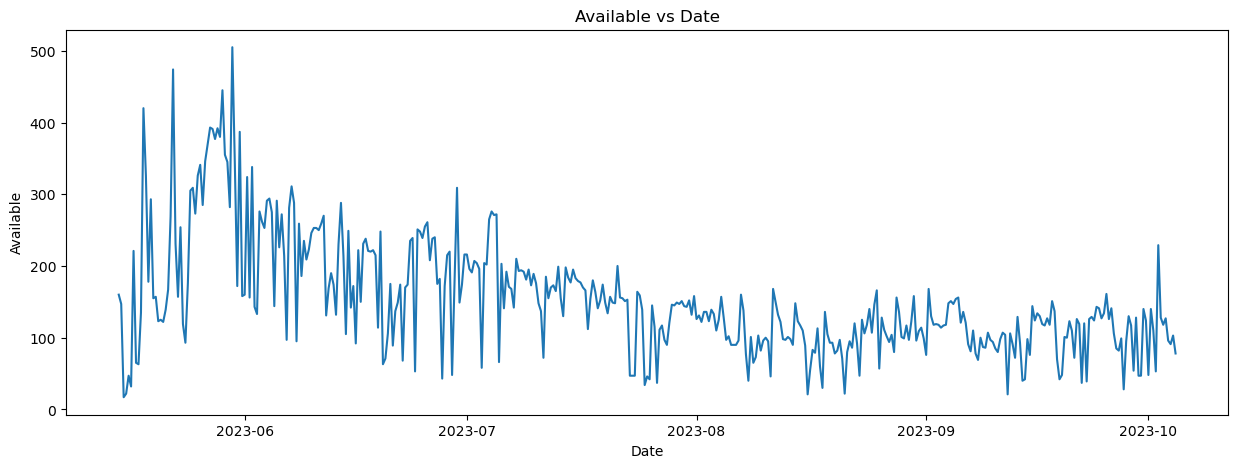

In [10]:
#px.line(lavb_8h, x="date", y="available", markers = True)
#Do the same but with matplotlib
plt.figure(figsize=(15,5))
plt.plot(lavb_8h['date'], lavb_8h['available'])
plt.xlabel('Date')
plt.ylabel('Available')
plt.title('Available vs Date')
plt.show()

<module 'matplotlib.pyplot' from 'c:\\Users\\USUARIO\\anaconda3\\envs\\Augusto\\lib\\site-packages\\matplotlib\\pyplot.py'>

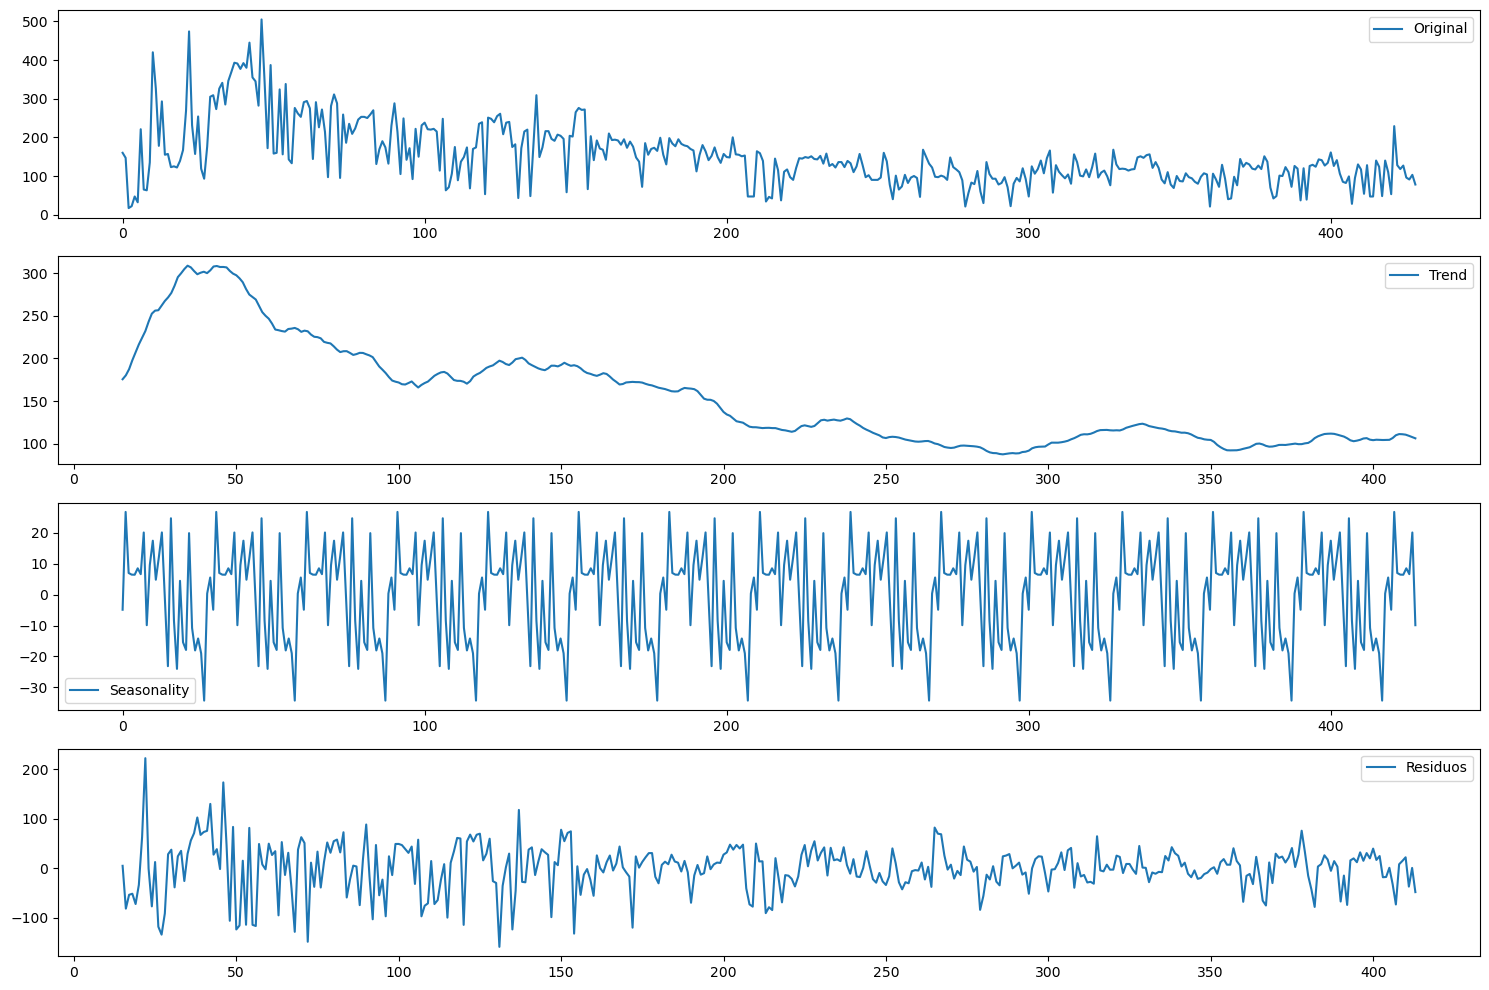

In [11]:
plot_descomposition(lavb_8h, "available")

In [26]:
#Dickie Fuller Test for stationarity
from statsmodels.tsa.stattools import adfuller
result = adfuller(lavb_8h['available'])
print('ADF Statistic: %f' % result[0])

ADF Statistic: -2.007135


The Dickie Fuller test is conducted to confirm for any statistical evidence for stationarity on our time series, an ADF statistic of -2.007135 is not statistically significant at the 5% level, which is a commonly used significance level for time series analysis.

In [12]:
df_features = create_features(lavb_8h.copy(), "date")
df_features

,origin,destination,available,hour,dayofweek,month,dayofyear,dayofmonth,weekofyear
date,,,,,,,,,
2023-05-15 00:00:00,Los Angeles (CA),Stockton (CA),160.0,0,0,5,135,15,20
2023-05-15 08:00:00,Los Angeles (CA),Stockton (CA),147.0,8,0,5,135,15,20
2023-05-15 16:00:00,Los Angeles (CA),Stockton (CA),17.0,16,0,5,135,15,20
2023-05-16 00:00:00,Los Angeles (CA),Stockton (CA),22.0,0,1,5,136,16,20
2023-05-16 08:00:00,Los Angeles (CA),Stockton (CA),47.0,8,1,5,136,16,20
...,...,...,...,...,...,...,...,...,...
2023-10-03 08:00:00,Los Angeles (CA),Stockton (CA),127.0,8,1,10,276,3,40
2023-10-03 16:00:00,Los Angeles (CA),Stockton (CA),96.0,16,1,10,276,3,40
2023-10-04 00:00:00,Los Angeles (CA),Stockton (CA),91.0,0,2,10,277,4,40


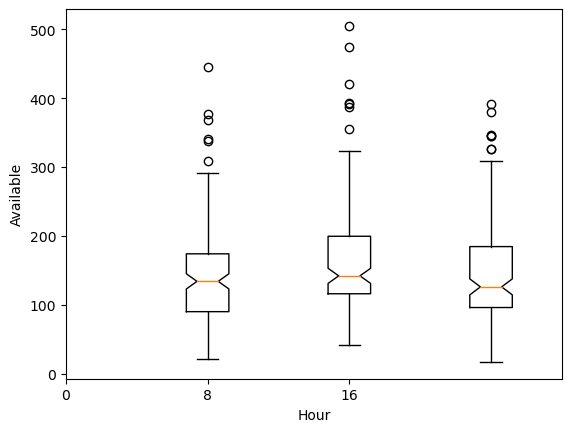

In [16]:
# Create a list of lists to store the data for each group
data = []
for hour in [0,8,16]:
    group_data = df_features[df_features["hour"] == hour]["available"].tolist()
    data.append(group_data)

# Create the boxplot
plt.boxplot(data, notch=True)

# Set the x-axis labels
plt.xticks(range(len(data)), df_features["hour"].unique())
plt.xlabel("Hour")
plt.ylabel("Available")

# Show the plot
plt.show()

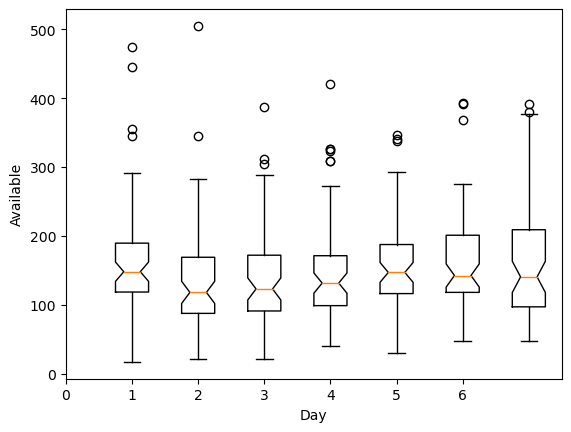

In [19]:
# Create a list of lists to store the data for each group
data = []
for date in df_features["dayofweek"].unique():
    group_data = df_features[df_features["dayofweek"] == date]["available"].tolist()
    data.append(group_data)

# Create the boxplot
plt.boxplot(data, notch=True)

# Set the x-axis labels
plt.xticks(range(len(data)), df_features["dayofweek"].unique())
plt.xlabel("Day")
plt.ylabel("Available")

# Show the plot
plt.show()

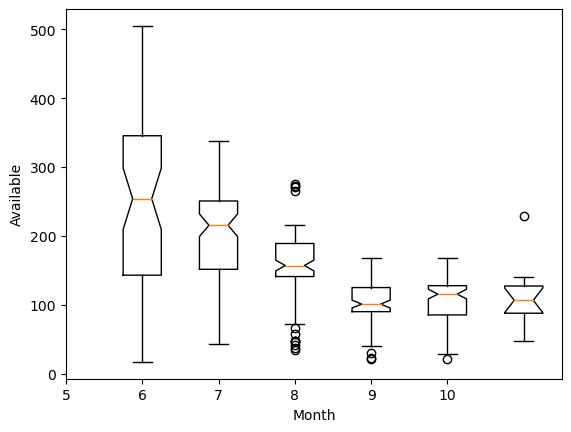

In [20]:
# Create a list of lists to store the data for each group
data = []
for month in df_features["month"].unique():
    group_data = df_features[df_features["month"] == month]["available"].tolist()
    data.append(group_data)

# Create the boxplot
plt.boxplot(data, notch=True)

# Set the x-axis labels
plt.xticks(range(len(data)), df_features["month"].unique())
plt.xlabel("Month")
plt.ylabel("Available")

# Show the plot
plt.show()

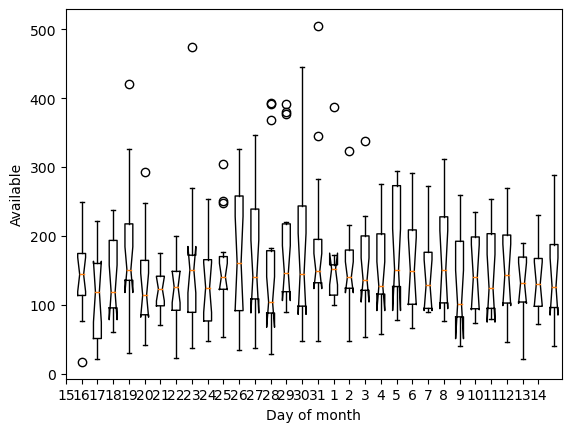

In [23]:
# Create a list of lists to store the data for each group
data = []
for date in df_features["dayofmonth"].unique():
    group_data = df_features[df_features["dayofmonth"] == date]["available"].tolist()
    data.append(group_data)

# Create the boxplot
plt.boxplot(data, notch=True)

# Set the x-axis labels
plt.xticks(range(len(data)), df_features["dayofmonth"].unique())
plt.xlabel("Day of month")
plt.ylabel("Available")

# Show the plot
plt.show()

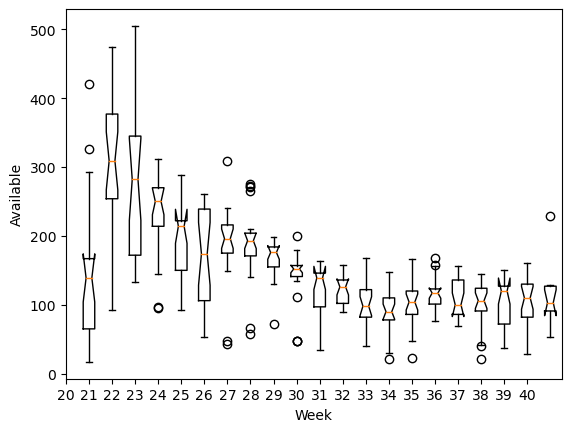

In [24]:
# Create a list of lists to store the data for each group
data = []
for date in df_features["weekofyear"].unique():
    group_data = df_features[df_features["weekofyear"] == date]["available"].tolist()
    data.append(group_data)

# Create the boxplot
plt.boxplot(data, notch=True)

# Set the x-axis labels
plt.xticks(range(len(data)), df_features["weekofyear"].unique())
plt.xlabel("Week")
plt.ylabel("Available")

# Show the plot
plt.show()

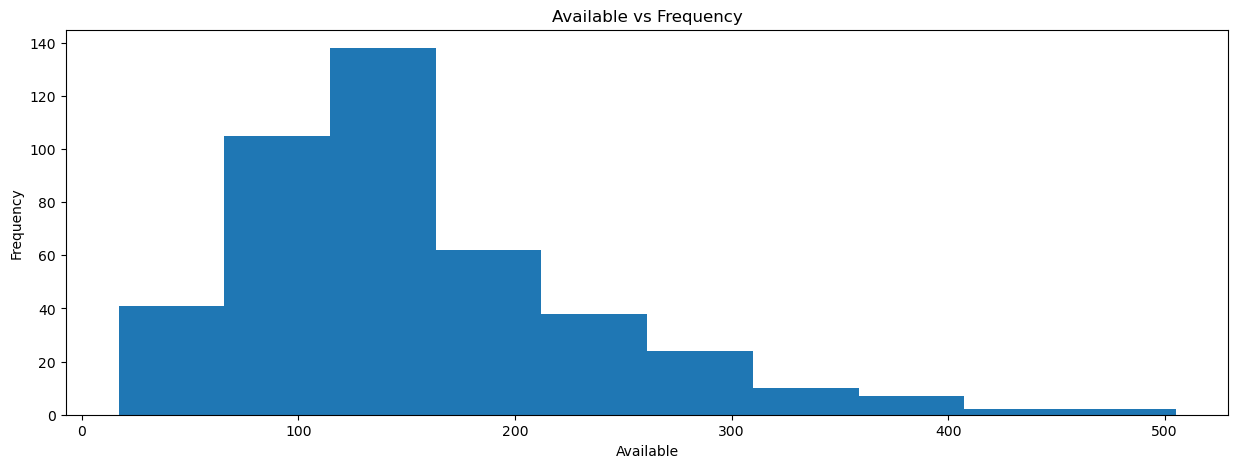

In [25]:
#px.histogram(df_features, x="available", animation_frame='month')
#Do the same but with matplotlib
plt.figure(figsize=(15,5))
plt.hist(df_features['available'])
plt.xlabel('Available')
plt.ylabel('Frequency')
plt.title('Available vs Frequency')
plt.show()

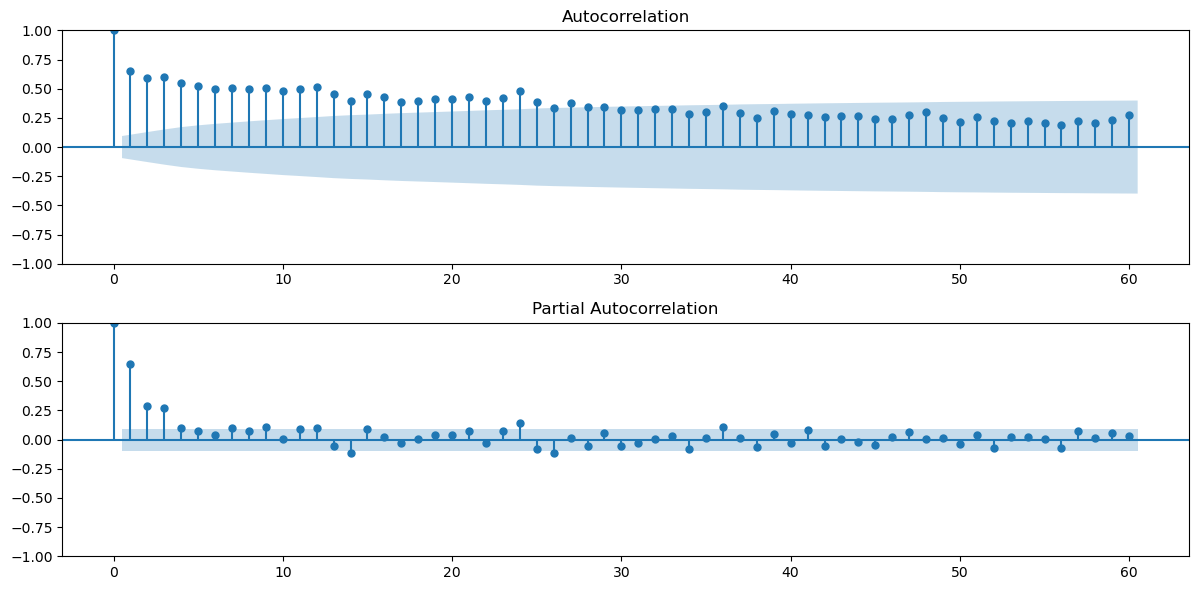

In [354]:
# Gráficos de autocorrelación y autocorrelación parcial
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plot_acf(lavb_8h['available'], ax=plt.gca(), lags=60)

plt.subplot(2, 1, 2)
plot_pacf(lavb_8h['available'], ax=plt.gca(), lags=60)

plt.tight_layout()
plt.show()

In [11]:
df_features = df_features.drop(['hour', 'dayofweek', 'month', 'dayofyear', 'dayofmonth', 'weekofyear'], axis=1)
df_features = add_lags(df_features, "available", 3)
df_features

,origin,destination,available,lag1,lag2,lag3
date,,,,,,
2023-05-15 00:00:00,Los Angeles (CA),Stockton (CA),160.0,NaN,NaN,NaN
2023-05-15 08:00:00,Los Angeles (CA),Stockton (CA),147.0,160.0,NaN,NaN
2023-05-15 16:00:00,Los Angeles (CA),Stockton (CA),17.0,147.0,160.0,NaN
2023-05-16 00:00:00,Los Angeles (CA),Stockton (CA),22.0,17.0,147.0,160.0
2023-05-16 08:00:00,Los Angeles (CA),Stockton (CA),47.0,22.0,17.0,147.0
...,...,...,...,...,...,...
2023-10-03 08:00:00,Los Angeles (CA),Stockton (CA),127.0,118.0,128.0,229.0
2023-10-03 16:00:00,Los Angeles (CA),Stockton (CA),96.0,127.0,118.0,128.0
2023-10-04 00:00:00,Los Angeles (CA),Stockton (CA),91.0,96.0,127.0,118.0


In [12]:
df_features = df_features.dropna()
df_features

,origin,destination,available,lag1,lag2,lag3
date,,,,,,
2023-05-16 00:00:00,Los Angeles (CA),Stockton (CA),22.0,17.0,147.0,160.0
2023-05-16 08:00:00,Los Angeles (CA),Stockton (CA),47.0,22.0,17.0,147.0
2023-05-16 16:00:00,Los Angeles (CA),Stockton (CA),32.0,47.0,22.0,17.0
2023-05-17 00:00:00,Los Angeles (CA),Stockton (CA),221.0,32.0,47.0,22.0
2023-05-17 08:00:00,Los Angeles (CA),Stockton (CA),65.0,221.0,32.0,47.0
...,...,...,...,...,...,...
2023-10-03 08:00:00,Los Angeles (CA),Stockton (CA),127.0,118.0,128.0,229.0
2023-10-03 16:00:00,Los Angeles (CA),Stockton (CA),96.0,127.0,118.0,128.0
2023-10-04 00:00:00,Los Angeles (CA),Stockton (CA),91.0,96.0,127.0,118.0


In [15]:
X = df_features.drop(columns=['available', 'origin', 'destination'])
y = df_features['available']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# KNN Model

In [16]:
# Apply KNN to forecast my time series (available) tunning hyperparamets without cross validation
grid_knn = None
if (len(glob.glob("knn_model_naugd.pkl")) != 0):
    
     grid_knn = pickle.load(open('knn_model_naugd.pkl','rb'))
     
else:
    
    pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('knn', KNeighborsRegressor())])
    
    param_grid = {'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    'knn__weights': ['uniform', 'distance'],
                    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                    'knn__leaf_size': [10, 20, 30, 40, 50],
                    'knn__p': [1, 2]}

    grid_knn = GridSearchCV(pipe, param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)
    grid_knn.fit(X_train, y_train)
    # Export model to pickle
    pickle.dump(grid_knn, open('knn_model_naugd.pkl', 'wb'))
    
print("Best parameters: ", grid_knn.best_params_)
print("Best score: ", grid_knn.best_score_)


Best parameters:  {'knn__algorithm': 'ball_tree', 'knn__leaf_size': 20, 'knn__n_neighbors': 10, 'knn__p': 1, 'knn__weights': 'distance'}
Best score:  -3222.5876841965273


In [17]:
# Predictions
y_pred = grid_knn.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = grid_knn.score(X_test, y_test)
models_metrics = [{'Model': 'KNN', 'MSE': mse, 'RMSE':mse**0.5, 'MAPE': mape, 'R2': r2}]
print(models_metrics)

#Plot predictions vs real values but with matplotlib
plt.figure(figsize=(15,5))
plt.plot(X_test.index, y_test, label='Real')
plt.plot(X_test.index, y_pred, label='Predicción')
plt.xlabel('Date')
plt.ylabel('Available')
plt.title('Predicción vs Real (KNN)')
plt.legend(loc='best')
plt.show()

[{'Model': 'KNN', 'MSE': 1295.5237527506472, 'RMSE': 35.993384847088876, 'MAPE': 0.40607448792176354}]


# Ridge

In [18]:
# Apply Ridge to forecast my time series (available) tunning hyperparamets without cross validation

if (len(glob.glob("ridge_model_naugd.pkl")) != 0):
    
    grid_rdg = pickle.load(open('ridge_model_naugd.pkl','rb'))
        
else:

    pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('ridge', Ridge())])

    param_grid = {'ridge__alpha': [0.1, 0.5, 1, 5, 10, 50, 100],
                    'ridge__solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

    grid_rdg = GridSearchCV(pipe, param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)
    grid_rdg.fit(X_train, y_train)
    # Export model to pickle
    pickle.dump(grid_rdg, open('ridge_model_naugd.pkl', 'wb'))
    
print("Best parameters: ", grid_rdg.best_params_)
print("Best score: ", grid_rdg.best_score_)

Best parameters:  {'ridge__alpha': 0.1, 'ridge__solver': 'sag'}
Best score:  -2704.997285950826


In [19]:
# Calculate metrics
y_pred = grid_rdg.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = grid_rdg.score(X_test, y_test)
models_metrics.append({'Model': 'Ridge', 'MSE': mse, 'RMSE':mse**0.5, 'MAPE': mape, 'R2': r2})
print(models_metrics)

#Plot predictions vs real values but with matplotlib
plt.figure(figsize=(15,5))
plt.plot(X_test.index, y_test, label='Real')
plt.plot(X_test.index, y_pred, label='Predicción')
plt.xlabel('Date')
plt.ylabel('Available')
plt.title('Predicción vs Real (Ridge)')
plt.legend(loc='best')
plt.show()

[{'Model': 'KNN', 'MSE': 1295.5237527506472, 'RMSE': 35.993384847088876, 'MAPE': 0.40607448792176354}, {'Model': 'Ridge', 'MSE': 1448.867944346486, 'RMSE': 38.063998007914066, 'MAPE': 0.4522864563680011}]


# Lasso

In [20]:
# Apply Lasso to forecast my time series (available) tunning hyperparamets without cross validation

if (len(glob.glob("lasso_model_naugd.pkl")) != 0):
        
    grid_lss = pickle.load(open('lasso_model_naugd.pkl','rb'))
        
else:
        
    pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('lasso', Lasso())])

    param_grid = {'lasso__alpha': [0.1, 0.5, 1, 5, 10, 50, 100],
                    'lasso__selection': ['cyclic', 'random']}
    
    grid_lss = GridSearchCV(pipe, param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)
    grid_lss.fit(X_train, y_train)
    
    # Export model to pickle
    pickle.dump(grid_lss, open('lasso_model_naugd.pkl', 'wb'))
        
print("Best parameters: ", grid_lss.best_params_)
print("Best score: ", grid_lss.best_score_)

Best parameters:  {'lasso__alpha': 0.1, 'lasso__selection': 'random'}
Best score:  -2717.625599038759


In [21]:
# Calculate metrics
y_pred = grid_lss.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = grid_lss.score(X_test, y_test)
models_metrics.append({'Model': 'Lasso', 'MSE': mse, 'RMSE':mse**0.5, 'MAPE': mape, 'R2': r2})
print(models_metrics)

#Plot predictions vs real values but with matplotlib
plt.figure(figsize=(15,5))
plt.plot(X_test.index, y_test, label='Real')
plt.plot(X_test.index, y_pred, label='Predicción')
plt.xlabel('Date')
plt.ylabel('Available')
plt.title('Predicción vs Real (Lasso)')
plt.legend(loc='best')
plt.show()

[{'Model': 'KNN', 'MSE': 1295.5237527506472, 'RMSE': 35.993384847088876, 'MAPE': 0.40607448792176354}, {'Model': 'Ridge', 'MSE': 1448.867944346486, 'RMSE': 38.063998007914066, 'MAPE': 0.4522864563680011}, {'Model': 'Lasso', 'MSE': 1457.7905125089944, 'RMSE': 38.18102293691192, 'MAPE': 0.45454360898826485}]


# Naive Bayes

In [22]:
# Apply Naive Bayes to forecast my time series (available) tunning hyperparamets without cross validation
if (len(glob.glob("naive_model_naugd.pkl")) != 0):
    
    grid_nb = pickle.load(open('naive_model_naugd.pkl','rb'))
    
else:
    
    nb = GaussianNB()
    param_grid = {'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]}
    
    grid_nb = GridSearchCV(nb, param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)
    grid_nb.fit(X_train, y_train)
    
    # Export model to pickle
    pickle.dump(grid_nb, open('naive_model_naugd.pkl', 'wb'))
    
print("Best parameters: ", grid_nb.best_params_)
print("Best score: ", grid_nb.best_score_)

Best parameters:  {'var_smoothing': 1e-05}
Best score:  -6869.128571428571


In [23]:
# Calculate metrics
y_pred = grid_nb.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = grid_nb.score(X_test, y_test)
models_metrics.append({'Model': 'Naive Bayes', 'MSE': mse, 'RMSE':mse**0.5, 'MAPE': mape, 'R2': r2})
print(models_metrics)

#Plot predictions vs real values but with matplotlib
plt.figure(figsize=(15,5))
plt.plot(X_test.index, y_test, label='Real')
plt.plot(X_test.index, y_pred, label='Predicción')
plt.xlabel('Date')
plt.ylabel('Available')
plt.title('Predicción vs Real (Naive Bayes)')
plt.legend(loc='best')
plt.show()

[{'Model': 'KNN', 'MSE': 1295.5237527506472, 'RMSE': 35.993384847088876, 'MAPE': 0.40607448792176354}, {'Model': 'Ridge', 'MSE': 1448.867944346486, 'RMSE': 38.063998007914066, 'MAPE': 0.4522864563680011}, {'Model': 'Lasso', 'MSE': 1457.7905125089944, 'RMSE': 38.18102293691192, 'MAPE': 0.45454360898826485}, {'Model': 'Naive Bayes', 'MSE': 1646.1860465116279, 'RMSE': 40.57321834057076, 'MAPE': 0.4209167208472928}]


# XGBoost

In [24]:
# Apply XGBoost to forecast my time series (available) tunning hyperparamets without cross validation
from xgboost import XGBRegressor

if (len(glob.glob("xgb_model_naugd.pkl")) != 0):
    
    grid_xgb = pickle.load(open('xgb_model_naugd.pkl','rb'))
    
else:
    
    xgb = XGBRegressor()
    param_grid = {'n_estimators': [100, 500, 1000],
                    'max_depth': [3, 5, 10],
                    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3]}
    
    grid_xgb = GridSearchCV(xgb, param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)
    grid_xgb.fit(X_train, y_train)
    
    # Export model to pickle
    pickle.dump(grid_xgb, open('xgb_model_naugd.pkl', 'wb'))

print("Best parameters: ", grid_xgb.best_params_)
print("Best score: ", grid_xgb.best_score_)

Best parameters:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Best score:  -4063.5291337231256


In [25]:
# Calculate metrics
y_pred = grid_xgb.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = grid_xgb.score(X_test, y_test)
models_metrics.append({'Model': 'XGBoost', 'MSE': mse, 'RMSE':mse**0.5, 'MAPE': mape, 'R2': r2})
print(models_metrics)

#Plot predictions vs real values but with matplotlib
plt.figure(figsize=(15,5))
plt.plot(X_test.index, y_test, label='Real')
plt.plot(X_test.index, y_pred, label='Predicción')
plt.xlabel('Date')
plt.ylabel('Available')
plt.title('Predicción vs Real (XGBoost)')
plt.legend(loc='best')
plt.show()

[{'Model': 'KNN', 'MSE': 1295.5237527506472, 'RMSE': 35.993384847088876, 'MAPE': 0.40607448792176354}, {'Model': 'Ridge', 'MSE': 1448.867944346486, 'RMSE': 38.063998007914066, 'MAPE': 0.4522864563680011}, {'Model': 'Lasso', 'MSE': 1457.7905125089944, 'RMSE': 38.18102293691192, 'MAPE': 0.45454360898826485}, {'Model': 'Naive Bayes', 'MSE': 1646.1860465116279, 'RMSE': 40.57321834057076, 'MAPE': 0.4209167208472928}, {'Model': 'XGBoost', 'MSE': 1502.7373898429344, 'RMSE': 38.76515690466033, 'MAPE': 0.43473268232847584}]


# SVM

In [26]:
# Apply SVM to forecast my time series (available) tunning hyperparamets without cross validation
if (len(glob.glob("svm_model_naugd.pkl")) != 0):
    
    grid_svm = pickle.load(open('svm_model_naugd.pkl','rb'))
    
else:

    pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('svm', SVR())])
    
    param_grid = {'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                    'svm__degree': [1, 2, 3, 4, 5],
                    'svm__gamma': ['scale', 'auto']}
    
    grid_svm = GridSearchCV(pipe, param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)
    grid_svm.fit(X_train, y_train)
    
    # Export model to pickle
    pickle.dump(grid_svm, open('svm_model_naugd.pkl', 'wb'))
    
print("Best parameters: ", grid_svm.best_params_)
print("Best score: ", grid_svm.best_score_)

Best parameters:  {'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'poly'}
Best score:  -2875.0486343630682


In [27]:
# Calculate metrics
y_pred = grid_svm.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = grid_svm.score(X_test, y_test)
models_metrics.append({'Model': 'SVM', 'MSE': mse, 'RMSE':mse**0.5, 'MAPE': mape, 'R2': r2})
print(models_metrics)

#Plot predictions vs real values but with matplotlib
plt.figure(figsize=(15,5))
plt.plot(X_test.index, y_test, label='Real')
plt.plot(X_test.index, y_pred, label='Predicción')
plt.xlabel('Date')
plt.ylabel('Available')
plt.title('Predicción vs Real (SVM)')
plt.legend(loc='best')
plt.show()

[{'Model': 'KNN', 'MSE': 1295.5237527506472, 'RMSE': 35.993384847088876, 'MAPE': 0.40607448792176354}, {'Model': 'Ridge', 'MSE': 1448.867944346486, 'RMSE': 38.063998007914066, 'MAPE': 0.4522864563680011}, {'Model': 'Lasso', 'MSE': 1457.7905125089944, 'RMSE': 38.18102293691192, 'MAPE': 0.45454360898826485}, {'Model': 'Naive Bayes', 'MSE': 1646.1860465116279, 'RMSE': 40.57321834057076, 'MAPE': 0.4209167208472928}, {'Model': 'XGBoost', 'MSE': 1502.7373898429344, 'RMSE': 38.76515690466033, 'MAPE': 0.43473268232847584}, {'Model': 'SVM', 'MSE': 1567.699634688578, 'RMSE': 39.5941868800027, 'MAPE': 0.48970962923289785}]


# MLP

In [28]:
# Apply MLP to forecast my time series (available) tunning hyperparamets without cross validation, do the required steps
# to apply the model

if (len(glob.glob("mlp_model_naugd.pkl")) != 0):
    
    grid_mlp = pickle.load(open('mlp_model_naugd.pkl','rb'))
    
else:

    pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('mlp', MLPRegressor())])

    param_grid = {'mlp__hidden_layer_sizes': [(10,), (50,), (100,)],
                    'mlp__activation': ['identity', 'logistic', 'tanh', 'relu'],
                    'mlp__solver': ['lbfgs', 'sgd', 'adam'],
                    'mlp__learning_rate': ['constant', 'invscaling', 'adaptive']}
    
    grid_mlp = GridSearchCV(pipe, param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)
    grid_mlp.fit(X_train, y_train)
    
    # Export model to pickle
    pickle.dump(grid_mlp, open('mlp_model_naugd.pkl', 'wb'))
    
print("Best parameters: ", grid_mlp.best_params_)
print("Best score: ", grid_mlp.best_score_)

Best parameters:  {'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (10,), 'mlp__learning_rate': 'constant', 'mlp__solver': 'sgd'}
Best score:  -2579.6601437229


In [29]:
# Calculate metrics
y_pred = grid_mlp.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = grid_mlp.score(X_test, y_test)
models_metrics.append({'Model': 'MLP', 'MSE': mse, 'RMSE':mse**0.5, 'MAPE': mape, 'R2': r2})
print(models_metrics)

# Plot predictions vs real values but with matplotlib
plt.figure(figsize=(15,5))
plt.plot(X_test.index, y_test, label='Real')
plt.plot(X_test.index, y_pred, label='Predicción')
plt.xlabel('Date')
plt.ylabel('Available')
plt.title('Predicción vs Real (MLP)')
plt.legend(loc='best')
plt.show()

[{'Model': 'KNN', 'MSE': 1295.5237527506472, 'RMSE': 35.993384847088876, 'MAPE': 0.40607448792176354}, {'Model': 'Ridge', 'MSE': 1448.867944346486, 'RMSE': 38.063998007914066, 'MAPE': 0.4522864563680011}, {'Model': 'Lasso', 'MSE': 1457.7905125089944, 'RMSE': 38.18102293691192, 'MAPE': 0.45454360898826485}, {'Model': 'Naive Bayes', 'MSE': 1646.1860465116279, 'RMSE': 40.57321834057076, 'MAPE': 0.4209167208472928}, {'Model': 'XGBoost', 'MSE': 1502.7373898429344, 'RMSE': 38.76515690466033, 'MAPE': 0.43473268232847584}, {'Model': 'SVM', 'MSE': 1567.699634688578, 'RMSE': 39.5941868800027, 'MAPE': 0.48970962923289785}, {'Model': 'MLP', 'MSE': 1448.0437828010265, 'RMSE': 38.05317046976541, 'MAPE': 0.45151003886932595}]


# Results

In [31]:
results_metrics_naug = pd.DataFrame(models_metrics)
results_metrics_naug

,Model,MSE,RMSE,MAPE
0,KNN,1295.523753,35.993385,0.406074
1,Ridge,1448.867944,38.063998,0.452286
2,Lasso,1457.790513,38.181023,0.454544
3,Naive Bayes,1646.186047,40.573218,0.420917
4,XGBoost,1502.737390,38.765157,0.434733
5,SVM,1567.699635,39.594187,0.489710
6,MLP,1448.043783,38.053170,0.451510


In [32]:
px.line_polar(results_metrics_naug, r='MAPE', theta='Model', line_close=True, title='MAPE por modelo')

In [ ]:
# Create the polar axes
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))

# Get the data from the DataFrame
theta = results_metrics_naug['Model'].to_numpy()
r = results_metrics_naug['MAPE'].to_numpy()

# Plot the lines
for i in range(len(theta)):
    ax.plot(theta[i], r[i], label=results_metrics_naug['Model'].iloc[i])

# Add a legend
ax.legend()

# Set the title and labels
ax.set_title('MAPE por modelo')
ax.set_xlabel('Modelo')
ax.set_ylabel('MAPE')

# Close the figure
plt.show()

Summing things up, our attempt to forecast the daily demand for truck transport in the USA was hindered by the limited data available in our time series. Despite employing a variety of models, including KNN, Naive Bayes, XGBoost, SVM, and MLP among others, the most successful one, KNN, yielded a Mean Absolute Percentage Error (MAPE) of 0.40. While this performance is suboptimal, it aligns with the challenges posed by the insufficient dataset. Recognizing the impact of data scarcity on our results, future endeavors should focus on gathering more comprehensive and detailed data to enhance the accuracy of our predictions. This would undoubtedly lead to more reliable forecasts, providing valuable insights for the optimization of truck transport operations in the USA.